In [1]:
using CSV
using Random
using StatsBase
using DataFrames
using Turing
using StatsPlots
using StatsFuns
using LaTeXStrings
using StatisticalRethinking
using StatisticalRethinking: link
using StatisticalRethinkingPlots
using ParetoSmooth
using ParetoSmoothedImportanceSampling
using Logging

default(labels=false)
Logging.disable_logging(Logging.Warn);

# 8.1 Building an interaction

Code 8.1

In [2]:
d = DataFrame(CSV.File("data/rugged.csv"))
dd = d[completecases(d, :rgdppc_2000),:]
dd[:,:log_gdp] = log.(dd.rgdppc_2000);
dd[:,:log_gdp_std] = dd.log_gdp / mean(dd.log_gdp)
dd[:,:rugged_std] = dd.rugged / maximum(dd.rugged);

Code 8.2

In [3]:
r̄ = mean(dd.rugged_std)

@model function model_m8_1(rugged_std, log_gdp_std)
    σ ~ Exponential()
    a ~ Normal(1, 1)
    b ~ Normal(0, 1)
    μ = @. a + b * (rugged_std - r̄)
    log_gdp_std ~ MvNormal(μ, σ)
end

model_m8_1 (generic function with 2 methods)

Code 8.3

In [4]:
m8_1_p = sample(model_m8_1(dd.rugged_std, dd.log_gdp_std), Prior(), 1000)
m8_1_p_df = DataFrame(m8_1_p);

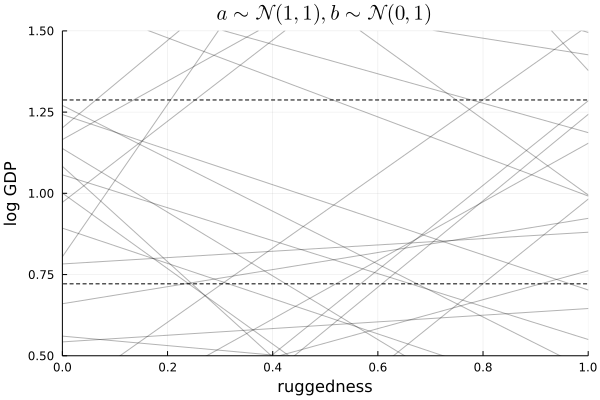

In [5]:
rugged_seq = range(-0.1, 1.1; length=30)
μ = link(m8_1_p_df, (r, x) -> r.a + r.b*(x - r̄), rugged_seq)
μ = hcat(μ...)

p = plot(
    xlim=(0, 1),
    ylim=(0.5, 1.5),
    title=L"a \sim \mathcal{N}(1,1), b \sim \mathcal{N}(0, 1)",
    xlab="ruggedness", ylab="log GDP",
)
hline!(collect(extrema(dd.log_gdp_std)); c=:black, s=:dash)
for μ₀ ∈ first(eachrow(μ), 50)
    plot!(rugged_seq, μ₀; c=:black, alpha=0.3)
end
p

Code 8.4

In [6]:
mean(abs.(m8_1_p_df.b) .> 0.6)

0.57

Code 8.5

In [7]:
r̄ = mean(dd.rugged_std)

@model function model_m8_1a(rugged_std, log_gdp_std)
    σ ~ Exponential()
    a ~ Normal(1, 0.1)
    b ~ Normal(0, 0.3)
    μ = @. a + b * (rugged_std - r̄)
    log_gdp_std ~ MvNormal(μ, σ)
end

m8_1 = sample(model_m8_1a(dd.rugged_std, dd.log_gdp_std), NUTS(), 1000)
m8_1_df = DataFrame(m8_1);

Code 8.6

In [8]:
precis(m8_1_df)

┌───────┬──────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%     50%   94.5%    histogram │
├───────┼──────────────────────────────────────────────────────┤
│     a │ 0.9997  0.0111   0.9826  0.9992  1.0168     ▁▁▄█▇▅▁▁ │
│     b │ 0.0001  0.0563  -0.0912   0.001  0.0864    ▁▁▅██▅▁▁▁ │
│     σ │ 0.1387  0.0075   0.1271  0.1384  0.1509  ▁▁▃██▇▅▂▁▁▁ │
└───────┴──────────────────────────────────────────────────────┘


Code 8.7

In [9]:
dd[:,:cid] = @. ifelse(dd.cont_africa == 1, 1, 2);

Code 8.8

In [10]:
@model function model_m8_2(rugged_std, cid,  log_gdp_std)
    σ ~ Exponential()
    a ~ MvNormal([1, 1], 0.1)
    b ~ Normal(0, 0.3)
    μ = @. a[cid] + b * (rugged_std - r̄)
    log_gdp_std ~ MvNormal(μ, σ)
end

m8_2 = sample(model_m8_2(dd.rugged_std, dd.cid,  dd.log_gdp_std), NUTS(), 1000)
m8_2_df = DataFrame(m8_2);

Code 8.9

In [11]:
# Compute log likelihoods for both models
fun = (r, (x,y)) -> normlogpdf(r.a + r.b * (x - r̄), r.σ, y)
m8_1_ll = link(m8_1_df, fun, zip(dd.rugged_std, dd.log_gdp_std))
m8_1_ll = hcat(m8_1_ll...)

# need DF with a as a vector of both a[1] and a[2]
df = DataFrame(m8_2_df)
df[!,:a] = collect.(zip(m8_2_df.:"a[1]", m8_2_df.:"a[2]"))

fun = (r, (x,c,y)) -> normlogpdf(r.a[c] + r.b * (x - r̄), r.σ, y)
m8_2_ll = link(df, fun, zip(dd.rugged_std, dd.cid, dd.log_gdp_std))
m8_2_ll = hcat(m8_2_ll...);

compare([m8_1_ll, m8_2_ll], :waic, mnames=["m8.1", "m8.2"])

,models,WAIC,lppd,SE,dWAIC,dSE,pWAIC,weight
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,m8.2,-252.0,-260.56,14.82,0.0,0.0,4.27,1.0
2,m8.1,-188.8,-193.98,12.87,63.2,14.67,2.6,0.0


Code 8.10

In [12]:
precis(m8_2_df)

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%        histogram │
├───────┼────────────────────────────────────────────────────────────┤
│  a[1] │  0.8808  0.0164   0.8546    0.881  0.9061      ▁▁▃▆██▇▃▁▁▁ │
│  a[2] │  1.0494  0.0102   1.0336   1.0494  1.0656  ▁▁▁▁▂▅▆██▆▄▂▁▁▁ │
│     b │ -0.0457   0.049  -0.1251  -0.0453  0.0324          ▁▁▃██▄▁ │
│     σ │  0.1143  0.0064   0.1043   0.1141  0.1253         ▁▂▅█▇▃▂▁ │
└───────┴────────────────────────────────────────────────────────────┘


Code 8.11

In [13]:
PI(map(r -> r[1] - r[2], df.a))

2-element Vector{Float64}:
 -0.19825561525781646
 -0.13851770975439429

Code 8.12

In [14]:
rugged_seq = range(-0.1, 1.1, length=30)
africa     = link(df, (r, x) -> r.a[1] + r.b*(x-r̄), rugged_seq)
africa     = hcat(africa...)'
not_africa = link(df, (r, x) -> r.a[2] + r.b*(x-r̄), rugged_seq)
not_africa = hcat(not_africa...)'

μₐ = mean.(eachrow(africa))
μₙ = mean.(eachrow(not_africa))
PIₐ = PI.(eachrow(africa))
PIₐ = vcat(PIₐ'...)
PIₙ = PI.(eachrow(not_africa))
PIₙ = vcat(PIₙ'...);

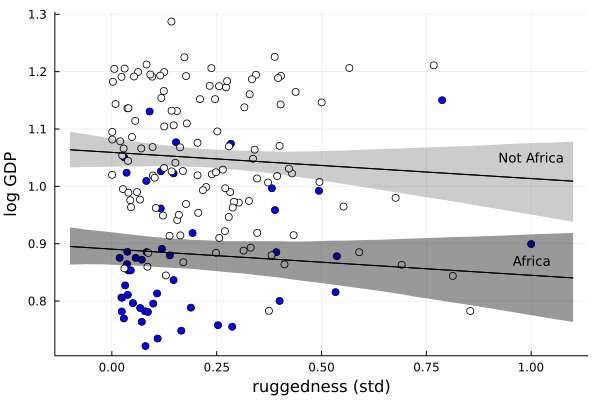

In [15]:
p = plot(xlab="ruggedness (std)", ylab="log GDP")
scatter!(dd.rugged_std[dd.cid.==1], dd.log_gdp_std[dd.cid.==1], c=:blue)
scatter!(dd.rugged_std[dd.cid.==2], dd.log_gdp_std[dd.cid.==2], c=:white)

plot!(rugged_seq, [μₐ, μₐ], c=:black, fillrange=PIₐ, fillalpha=0.4)
plot!(rugged_seq, [μₙ, μₙ], c=:black, fillrange=PIₙ, fillalpha=0.2)
annotate!([
    (1, 0.87, ("Africa", 9)),
    (1, 1.05, ("Not Africa", 9))
])

Code 8.13

In [16]:
@model function model_m8_3(rugged_std, cid,  log_gdp_std)
    σ ~ Exponential()
    a ~ MvNormal([1, 1], 0.1)
    b ~ MvNormal([0, 0], 0.3)
    μ = @. a[cid] + b[cid] * (rugged_std - r̄)
    log_gdp_std ~ MvNormal(μ, σ)
end

m8_3 = sample(model_m8_3(dd.rugged_std, dd.cid,  dd.log_gdp_std), NUTS(), 1000)
m8_3_df = DataFrame(m8_3);

Code 8.14

In [17]:
precis(m8_3_df)

┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std    5.5%      50%    94.5%      histogram │
├───────┼──────────────────────────────────────────────────────────┤
│  a[1] │  0.8873  0.0158  0.8635   0.8876   0.9123   ▁▁▁▂▄▇██▅▂▁▁ │
│  a[2] │   1.051  0.0102  1.0348   1.0509   1.0676  ▁▁▂▄▆██▆▅▃▁▁▁ │
│  b[1] │  0.1301  0.0754  0.0068   0.1318   0.2486    ▁▁▃▆█▇▄▂▁▁▁ │
│  b[2] │ -0.1399  0.0561  -0.231  -0.1404  -0.0515        ▁▃██▅▂▁ │
│     σ │  0.1114  0.0063  0.1019   0.1111   0.1223       ▁▄██▆▃▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


Code 8.15

In [18]:
df3 = DataFrame(m8_3_df)
df3[!,:a] = collect.(zip(m8_3_df.:"a[1]", m8_3_df.:"a[2]"))
df3[!,:b] = collect.(zip(m8_3_df.:"b[1]", m8_3_df.:"b[2]"))

fun = (r, (x,c,y)) -> normlogpdf(r.a[c] + r.b[c] * (x - r̄), r.σ, y)
m8_3_ll = link(df3, fun, zip(dd.rugged_std, dd.cid, dd.log_gdp_std))
m8_3_ll = hcat(m8_3_ll...);

compare([m8_1_ll, m8_2_ll, m8_3_ll], :psis, mnames=["m8.1", "m8.2", "m8.3"])

,models,PSIS,lppd,SE,dPSIS,dSE,pPSIS,weight
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,m8.3,-259.9,-269.18,14.56,0.0,0.0,5.02,0.98
2,m8.2,-252.5,-260.56,14.75,7.4,6.38,4.27,0.02
3,m8.1,-189.1,-193.98,12.84,70.8,14.77,2.6,0.0


Code 8.16

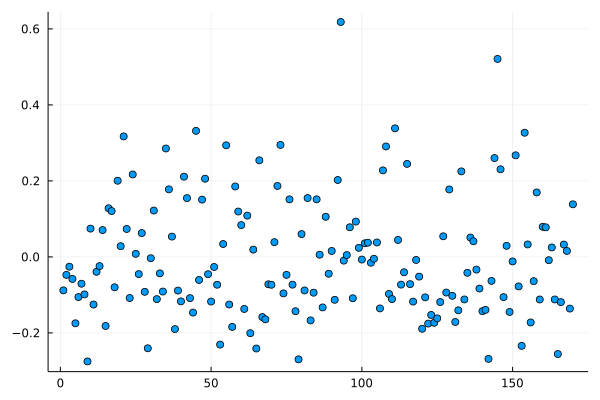

In [19]:
t = m8_3_ll'
m8_3_t = collect(reshape(t, size(t)..., 1))
PSIS_m8_3 = psis_loo(m8_3_t)
scatter(PSIS_m8_3.pointwise(:pareto_k))

Code 8.17

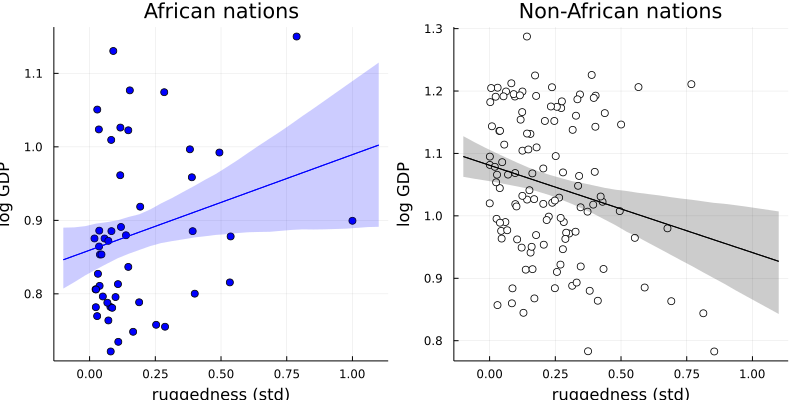

In [20]:
# build data
africa     = link(df3, (r, x) -> r.a[1] + r.b[1]*(x-r̄), rugged_seq)
africa     = hcat(africa...)'
not_africa = link(df3, (r, x) -> r.a[2] + r.b[2]*(x-r̄), rugged_seq)
not_africa = hcat(not_africa...)'

μₐ = mean.(eachrow(africa))
μₙ = mean.(eachrow(not_africa))
PIₐ = PI.(eachrow(africa))
PIₐ = vcat(PIₐ'...)
PIₙ = PI.(eachrow(not_africa))
PIₙ = vcat(PIₙ'...);

# plot Africa, cid=1
p1 = plot(xlab="ruggedness (std)", ylab="log GDP", title="African nations")
scatter!(dd.rugged_std[dd.cid.==1], dd.log_gdp_std[dd.cid.==1], c=:blue)
plot!(rugged_seq, [μₐ, μₐ], c=:blue, fillrange=PIₐ, fillalpha=0.2)

# plot non Africa, cid=2
p2 = plot(xlab="ruggedness (std)", ylab="log GDP", title="Non-African nations")
scatter!(dd.rugged_std[dd.cid.==2], dd.log_gdp_std[dd.cid.==2], c=:white)
plot!(rugged_seq, [μₙ, μₙ], c=:black, fillrange=PIₙ, fillalpha=0.2)

plot(p1, p2, size=(800, 400))

# 8.2 Symmetry of interations

Code 8.18

In [21]:
rugged_seq = range(-0.2, 1.2, length=30)
μA = link(df3, (r, x) -> r.a[1] + r.b[1]*(x-r̄), rugged_seq)
μA = vcat(μA'...)
μN = link(df3, (r, x) -> r.a[2] + r.b[2]*(x-r̄), rugged_seq)
μN = vcat(μN'...)
delta = μA .- μN;

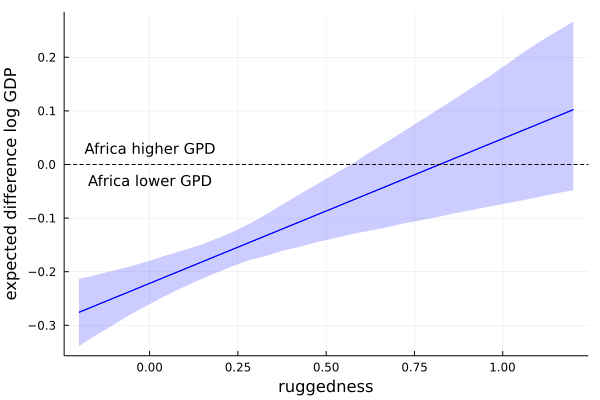

In [22]:
μ = mean.(eachrow(delta))
PI_v = PI.(eachrow(delta))
PI_v = vcat(PI_v'...)

plot(xlab="ruggedness", ylab="expected difference log GDP",)
plot!(rugged_seq, [μ, μ], c=:blue, fillrange=PI_v, fillalpha=0.2)
hline!([0.0], s=:dash, c=:black)
annotate!([
    (0.0, 0.03, ("Africa higher GPD", 10)),
    (0.0, -0.03, ("Africa lower GPD", 10)),
])

# 8.3 Continuous interaction

Code 8.19

In [23]:
d = DataFrame(CSV.File("data/tulips.csv"))
describe(d)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,bed,,a,,c,0,String1
2,water,2.0,1,2.0,3,0,Int64
3,shade,2.0,1,2.0,3,0,Int64
4,blooms,128.994,0.0,111.04,361.66,0,Float64


Code 8.20

In [24]:
d.blooms_std = d.blooms / maximum(d.blooms)
d.water_cent = d.water .- mean(d.water)
d.shade_cent = d.shade .- mean(d.shade);

Code 8.21

In [25]:
Random.seed!(1)
a = rand(Normal(0.5, 1), 10^4)
sum(@. (a < 0) | (a > 1))/length(a)

0.6176

Code 8.22

In [26]:
Random.seed!(1)
a = rand(Normal(0.5, 0.25), 10^4)
sum(@. (a < 0) | (a > 1))/length(a)

0.0469

Code 8.23

In [27]:
@model function m8_4(water_cent, shade_cent, blooms_std)
    a ~ Normal(0.5, 0.25)
    bw ~ Normal(0, 0.25)
    bs ~ Normal(0, 0.25)
    μ = @. a + bw*water_cent + bs*shade_cent
    σ ~ Exponential(1)
    blooms_std ~ MvNormal(μ, σ)
end

m8_4_c = sample(m8_4(d.water_cent, d.shade_cent, d.blooms_std), NUTS(), 1000)
m8_4_df = DataFrame(m8_4_c)
precis(m8_4_df)

┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%     histogram │
├───────┼──────────────────────────────────────────────────────────┤
│     a │    0.36  0.0344   0.3067   0.3596   0.4167   ▁▁▂▃▆██▅▄▂▁ │
│    bs │ -0.1111  0.0412  -0.1747  -0.1104  -0.0476       ▁▁▃█▆▂▁ │
│    bw │  0.2034  0.0414     0.14    0.203   0.2721       ▁▁▂██▃▁ │
│     σ │  0.1781  0.0291   0.1398   0.1741   0.2299  ▁▂▇█▆▄▂▁▁▁▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


Code 8.24

In [28]:
@model function m8_5(water_cent, shade_cent, blooms_std)
    a ~ Normal(0.5, 0.25)
    bw ~ Normal(0, 0.25)
    bs ~ Normal(0, 0.25)
    bws ~ Normal(0, 0.25)
    μ = @. a + bw*water_cent + bs*shade_cent + bws*water_cent*shade_cent
    σ ~ Exponential(1)
    blooms_std ~ MvNormal(μ, σ)
end

m8_5_c = sample(m8_5(d.water_cent, d.shade_cent, d.blooms_std), NUTS(), 1000)
m8_5_df = DataFrame(m8_5_c)
precis(m8_5_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     a │  0.3576  0.0286   0.3136   0.3586   0.4017  ▁▁▁▂▅██▄▂▁▁▁▁ │
│    bs │ -0.1131  0.0331  -0.1658  -0.1136  -0.0622  ▁▁▁▂▄▇█▇▃▂▁▁▁ │
│    bw │  0.2071  0.0334   0.1554   0.2064   0.2613         ▁▁▆█▂▁ │
│   bws │ -0.1404  0.0405  -0.2043  -0.1391  -0.0763         ▁▁▆█▃▁ │
│     σ │   0.142  0.0217   0.1121   0.1394   0.1777      ▁▄█▇▃▁▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


Code 8.25

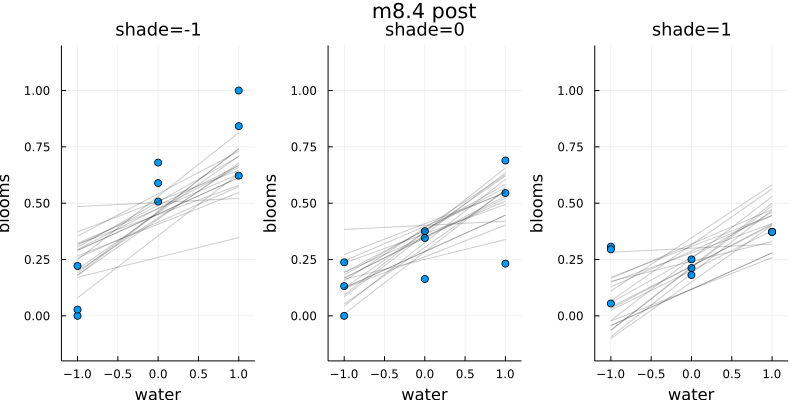

In [29]:
plts = []

for shade ∈ -1:1
    idx = findall(==(shade), d.shade_cent)
    p = plot(xlims=(-1.2,1.2), ylims=(-.2,1.2), xlab="water", ylab="blooms", 
             title="shade=$shade", titlefontsize=12)
    scatter!(d.water_cent[idx], d.blooms_std[idx])
    water_seq = -1:1
    mu = link(m8_4_df, (r, water) -> r.a + r.bw * water + r.bs * shade, water_seq)
    mu = hcat(mu...);
    for μ ∈ first(eachrow(mu), 20)
        plot!(water_seq, μ, c=:black, alpha=0.2)
    end
    push!(plts, p)
end
plot(plts..., layout=(1, 3), size=(800, 400), plot_title="m8.4 post", plot_titlefontsize=14)

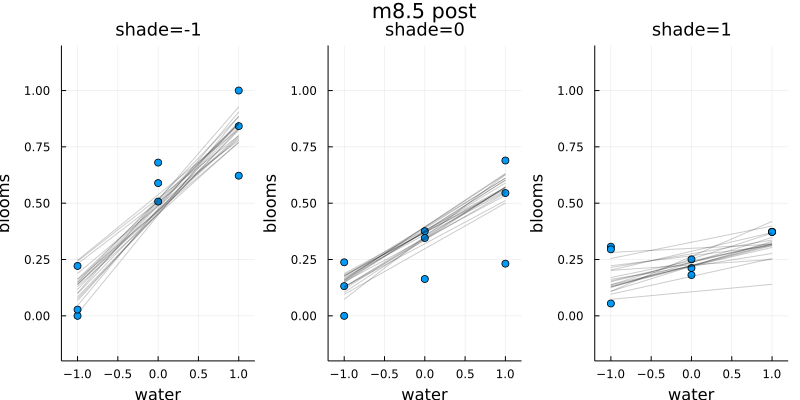

In [30]:
plts = []

for shade ∈ -1:1
    idx = findall(==(shade), d.shade_cent)
    p = plot(xlims=(-1.2,1.2), ylims=(-.2,1.2), xlab="water", ylab="blooms", 
             title="shade=$shade", titlefontsize=12)
    scatter!(d.water_cent[idx], d.blooms_std[idx])
    water_seq = -1:1
    mu = link(m8_5_df, (r, water) -> r.a + r.bw*water + r.bs*shade + r.bws*water*shade, water_seq)
    mu = hcat(mu...);
    for μ ∈ first(eachrow(mu), 20)
        plot!(water_seq, μ, c=:black, alpha=0.2)
    end
    push!(plts, p)
end
plot(plts..., layout=(1, 3), size=(800, 400), plot_title="m8.5 post", plot_titlefontsize=14)

Code 8.26

In [31]:
Random.seed!(7)
m8_5p_c = sample(m8_5(d.water_cent, d.shade_cent, d.blooms_std), Prior(), 1000)
m8_5p_df = DataFrame(m8_5p_c);

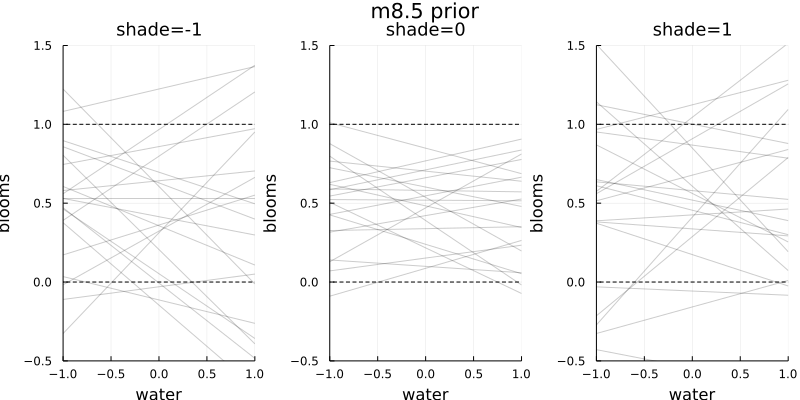

In [32]:
plts = []

for shade ∈ -1:1
    p = plot(xlims=(-1, 1), ylims=(-0.5, 1.5), xlab="water", ylab="blooms", 
             title="shade=$shade", titlefontsize=12)
    water_seq = -1:1
    mu = link(m8_5p_df, (r, water) -> r.a + r.bw*water + r.bs*shade + r.bws*water*shade, water_seq)
    mu = hcat(mu...);
    for μ ∈ first(eachrow(mu), 20)
        plot!(water_seq, μ, c=:black, alpha=0.2)
    end
    hline!([0.0, 1.0], s=:dash, c=:black)
    push!(plts, p)
end
plot(plts..., layout=(1, 3), size=(800, 400), plot_title="m8.5 prior", plot_titlefontsize=14)